# Semantic Segmentation on Aerial Images using Drone


Project Repository: [https://github.com/mr-ravin/Aerial-Semantic-Segmentation-Drone-using-Pytorch/](https://github.com/mr-ravin/Aerial-Semantic-Segmentation-Drone-using-Pytorch/)

- Aerial Image Dataset: https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset

- Number of Raw Classes: 24, indexed from 0 to 23. After processing this data, these classes are grouped into 5 classes, indexed from 0 to 4.

|  index | Class         |
|---------|--------------|
|    0    |  unlabeled   |
|    1    |  paved-area  |
|    2    |  dirt        |
|    3    |  grass       |
|    4    |  gravel      |
|    5    |  water       |
|    6    |  rocks       |
|    7    |  pool        |
|    8    |  vegetation  |
|    9    |  roof        |
|    10   |  wall        |
|    11   |  window      |
|    12   |  door        |
|    13   |  fence       |
|    14   |  fence-pole  |
|    15   |  person      |
|    16   |  dog         |
|    17   |  car         |
|    18   |  bicycle     |
|    19   |  tree        |
|    20   |  bald-tree   |
|    21   |  ar-marker   |
|    22   |  obstacle    |
|    23   |  conflicting |


### Final Number of Grouped Classes: 5

| grouped class id | individual classes                   | group color in rgb  | grouped class name  |
|------------------|--------------------------------------|---------------------|---------------------|
|        0         | 0, 6, 10, 11, 12, 13, 14, 21, 22, 23 |    [155,38,182]     | obstacles           |
|        1         | 5, 7                                 |    [14,135,204]     | water               |
|        2         | 2, 3, 8, 19, 20                      |    [124,252,0]      | nature              |
|        3         | 15, 16, 17, 18                       |    [255,20,147]     | moving              |
|        4         | 1, 4, 9                              |    [169,169,169]    | landable            |


# Package Installations


In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install opencv-python
!pip install albumentations
!pip install tqdm
!pip install segmentation_models_pytorch

In [2]:
root_dir = '.' # directory path

In [3]:
import sys
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
sys.path.append(root_dir)

## Initialisation of Parameters

In [4]:
LR = 2e-3
DIMy = 512
DIMx = 512
EPOCH = 25
DEVICE = "cuda"
individual_class_count=24
total_channels = 5 # total 5 grouped classes, indexed ranging from 0 to 4.
MODE = "train"
DO_DATA_SPLIT = False

## Create Data Split for train and val

Information regarding the images present in our train set is present inside `train_files.txt`and image information for validation set is present inside `valid_files.txt`. It's provided so that one can reproduce the results.

In [5]:
%load_ext autoreload
%autoreload 2
import utils.preprocess as utils_preprocess
%reload_ext autoreload

In [6]:
if MODE == "train" and DO_DATA_SPLIT == True:
    print("Generating Dataset...")
    utils_preprocess.data_split(root_dir)

## Visualise Dataset

In [7]:
import utils.graphics as utils_graphics

True

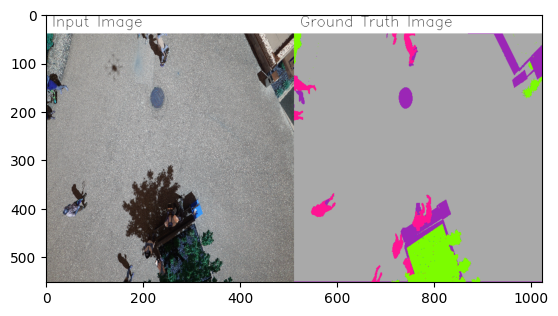

In [8]:
show_dimx, show_dimy = 512, 512
rgb_image = cv2.imread(root_dir+'/dataset/images/000.jpg')
rgb_image = cv2.resize(rgb_image, (show_dimx, show_dimy))
gt_label = cv2.imread(root_dir+'/dataset/masks/000.png', cv2.IMREAD_UNCHANGED)
gt_label = cv2.resize(gt_label, (show_dimx, show_dimy))
visualise_mask = utils_graphics.generate_rgb_mask(gt_label, total_channels, individual_class_count)
tagged_input_image = utils_graphics.add_tag_on_image(rgb_image, "Input Image")
tagged_label_image = utils_graphics.add_tag_on_image(visualise_mask, "Ground Truth Image")
combined_image = cv2.hconcat([tagged_input_image, tagged_label_image])
plt.imshow(combined_image)
combined_image = cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR)
cv2.imwrite(root_dir+"/results/view_dataset.jpg", combined_image)

## Model Architecture: FPN with EfficientNet-B3

In [9]:
%autoreload 3
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from dataloader import CustomImageDataset
import utils.compute as compute
import segmentation_models_pytorch as smp
%reload_ext autoreload

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [10]:

segmentation_model = smp.FPN(
    encoder_name="efficientnet-b3",
    in_channels=3,
    classes=total_channels,
)
sigmoid = nn.Sigmoid()
segmentation_model.to(DEVICE)

trainable_parameters = sum(p.numel() for p in segmentation_model.parameters() if p.requires_grad)
print("Number of Trainable parameters: ",trainable_parameters)

Number of Trainable parameters:  12475309


## Data Augmentation

In [11]:
IMAGE_HT, IMAGE_WT = DIMy, DIMx
train_transform = A.Compose(
            [   A.Resize(height=IMAGE_HT, width=IMAGE_WT, interpolation=cv2.INTER_NEAREST, p=1.0),
                A.Rotate(limit=45,p=0.35),
                A.HorizontalFlip(p=0.25),
                A.VerticalFlip(p=0.25),
                A.GridDistortion(p=0.20),
                A.RandomBrightnessContrast (brightness_limit=(-0.15, 0.15), contrast_limit=(-0.15, 0.15), p=0.25),
                A.GaussNoise(p=0.10),
                A.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
                ToTensorV2(),
            ],
            )
validation_transform = A.Compose(
            [   A.Resize(height=IMAGE_HT, width=IMAGE_WT, interpolation=cv2.INTER_NEAREST),
                A.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5],max_pixel_value=255.0,),
                ToTensorV2(),
            ],
            )

# Model Training

In [12]:
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_iou, epoch_vl_iou = [], []

In [13]:
# loss function
loss_fn = compute.CombinedLoss()

In [14]:
def train_model(root_dir, total_channels, train_transform, validation_transform, lr, total_epoch):
    global segmentation_model
    global epoch_tr_loss, epoch_vl_loss
    global epoch_tr_iou, epoch_vl_iou
    valid_loss_min = np.Inf
    valid_acc_max_iou_mean = -1

    # Optimizer and Scheduler
    optimizer = optim.Adam(segmentation_model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

    # Data Loading
    training_data = CustomImageDataset(root_dir=root_dir, total_channels = total_channels, transform=train_transform, mode="train", device=DEVICE)
    validation_data = CustomImageDataset(root_dir=root_dir, total_channels = total_channels, transform=validation_transform, mode="val", device=DEVICE)
    train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, pin_memory=True, num_workers=4)
    validation_dataloader = DataLoader(validation_data, batch_size=3, shuffle=True, pin_memory=True, num_workers=3)

    # training loop
    for ep in range(total_epoch):
        train_acc = 0.0
        valid_acc = 0.0
        valid_batch_run = 0
        train_batch_run = 0
        train_losses = []
        valid_losses = []
        segmentation_model.train()
        with tqdm(train_dataloader, unit=" Train batch") as tepoch:
            tepoch.set_description(f"Train Epoch {ep+1}")
            for input_images, target_masks, gt_paths in tepoch:
                input_images = input_images.to(DEVICE)
                target_masks = target_masks.to(DEVICE)
                train_batch_run += 1
                optimizer.zero_grad()
                output_masks = segmentation_model(input_images)
                output_masks = sigmoid(output_masks)
                output_masks = output_masks.squeeze(dim=1)
                loss_value = loss_fn(output_masks, target_masks.float())
                loss_value.backward()
                optimizer.step()
                train_losses.append(loss_value.item())
                accuracy_value = compute.get_iou_score(output_masks, target_masks.float())
                train_acc += accuracy_value
            scheduler.step()

        segmentation_model.eval()
        with tqdm(validation_dataloader, unit=" Valid batch") as vepoch:
            for input_images, target_masks, gt_paths in vepoch:
                valid_batch_run += 1
                input_images = input_images.to(DEVICE)
                target_masks = target_masks.to(DEVICE)
                with torch.no_grad():
                    output_masks = segmentation_model(input_images)
                    output_masks = sigmoid(output_masks)
                    output_masks = output_masks.squeeze(dim=1)
                    loss_value = loss_fn(output_masks, target_masks.float())
                    valid_losses.append(loss_value.item())
                    accuracy_value = compute.get_iou_score(output_masks, target_masks.float())
                    valid_acc += accuracy_value
        # matrices log
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(valid_losses)

        epoch_train_iou_mean = train_acc/train_batch_run
        epoch_valid_iou_mean = valid_acc/valid_batch_run

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)

        epoch_tr_iou.append(epoch_train_iou_mean)
        epoch_vl_iou.append(epoch_valid_iou_mean)

        print(f'Epoch {ep+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_iou_mean : {epoch_train_iou_mean*100} val_iou_mean : {epoch_valid_iou_mean*100}')
        if epoch_val_loss <= valid_loss_min or valid_acc_max_iou_mean <= epoch_valid_iou_mean*100 :
            if epoch_val_loss <= valid_loss_min:
                valid_loss_min = epoch_val_loss
            if valid_acc_max_iou_mean <= epoch_valid_iou_mean*100:
                valid_acc_max_iou_mean = epoch_valid_iou_mean*100
            os.system("rm "+root_dir+"/weights/*pt")
            print("removing stored weights of previous epoch")
            torch.save(segmentation_model.state_dict(), root_dir+"/weights/FPN_efficientnet_b3_"+str(ep+1)+".pt")
            print("storing weights of current epoch")

In [15]:
if MODE == "train":
    print("Training...")
    train_model(root_dir, total_channels, train_transform, validation_transform, LR, EPOCH)

Training...


Train Epoch 1:   0%|          | 0/85 [00:00<?, ? Train batch/s]

100%|██████████| 20/20 [01:24<00:00,  4.25s/ Valid batch]


Epoch 1
train_loss : 0.3465876815950169 val_loss : 0.6127519562840462
train_iou_mean : 39.009403228759766 val_iou_mean : 25.12979507446289
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:25<00:00,  4.28s/ Valid batch]


Epoch 2
train_loss : 0.2638934166992412 val_loss : 0.2943224012851715
train_iou_mean : 41.94923782348633 val_iou_mean : 40.60930252075195
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:25<00:00,  4.28s/ Valid batch]


Epoch 3
train_loss : 0.23234650597852818 val_loss : 0.40093152672052385
train_iou_mean : 43.27360534667969 val_iou_mean : 37.33104705810547


100%|██████████| 20/20 [01:25<00:00,  4.26s/ Valid batch]


Epoch 4
train_loss : 0.22996789497487685 val_loss : 0.23491987586021423
train_iou_mean : 43.49102783203125 val_iou_mean : 43.17238998413086
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:25<00:00,  4.27s/ Valid batch]


Epoch 5
train_loss : 0.19688489139080048 val_loss : 0.16983861178159715
train_iou_mean : 44.877479553222656 val_iou_mean : 45.90470886230469
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.24s/ Valid batch]


Epoch 6
train_loss : 0.1886415511369705 val_loss : 0.170610860735178
train_iou_mean : 45.20906066894531 val_iou_mean : 45.888973236083984


100%|██████████| 20/20 [01:24<00:00,  4.25s/ Valid batch]


Epoch 7
train_loss : 0.184398354677593 val_loss : 0.1621469471603632
train_iou_mean : 45.393070220947266 val_iou_mean : 46.3244514465332
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.24s/ Valid batch]


Epoch 8
train_loss : 0.17849029302597047 val_loss : 0.17590115927159786
train_iou_mean : 45.66164016723633 val_iou_mean : 45.72431564331055


100%|██████████| 20/20 [01:25<00:00,  4.25s/ Valid batch]


Epoch 9
train_loss : 0.1709595575052149 val_loss : 0.1567074567079544
train_iou_mean : 45.98933410644531 val_iou_mean : 46.52188491821289
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:25<00:00,  4.25s/ Valid batch]


Epoch 10
train_loss : 0.16277573354103986 val_loss : 0.15135067962110044
train_iou_mean : 46.363250732421875 val_iou_mean : 46.762535095214844
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.22s/ Valid batch]


Epoch 11
train_loss : 0.16254765926038517 val_loss : 0.1511682778596878
train_iou_mean : 46.37569808959961 val_iou_mean : 46.80076599121094
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.23s/ Valid batch]


Epoch 12
train_loss : 0.15772172983954935 val_loss : 0.151217719912529
train_iou_mean : 46.567588806152344 val_iou_mean : 46.804115295410156
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:25<00:00,  4.27s/ Valid batch]


Epoch 13
train_loss : 0.15600435234167997 val_loss : 0.14726029932498932
train_iou_mean : 46.648685455322266 val_iou_mean : 46.953025817871094
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.23s/ Valid batch]


Epoch 14
train_loss : 0.15359174311161042 val_loss : 0.14669913798570633
train_iou_mean : 46.758365631103516 val_iou_mean : 46.97883987426758
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.23s/ Valid batch]


Epoch 15
train_loss : 0.153826943127548 val_loss : 0.14575043134391308
train_iou_mean : 46.7356071472168 val_iou_mean : 47.0330924987793
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.25s/ Valid batch]


Epoch 16
train_loss : 0.1508741665412398 val_loss : 0.14571891836822032
train_iou_mean : 46.8706169128418 val_iou_mean : 47.01591873168945
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.21s/ Valid batch]


Epoch 17
train_loss : 0.15009038088952795 val_loss : 0.1457198817282915
train_iou_mean : 46.9054069519043 val_iou_mean : 47.0295295715332


100%|██████████| 20/20 [01:24<00:00,  4.24s/ Valid batch]


Epoch 18
train_loss : 0.14963397594059216 val_loss : 0.1448302071541548
train_iou_mean : 46.92444610595703 val_iou_mean : 47.07440948486328
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.23s/ Valid batch]


Epoch 19
train_loss : 0.1490981292198686 val_loss : 0.14394139796495437
train_iou_mean : 46.952640533447266 val_iou_mean : 47.10255432128906
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.21s/ Valid batch]


Epoch 20
train_loss : 0.14816019070499084 val_loss : 0.14437246993184089
train_iou_mean : 46.99121856689453 val_iou_mean : 47.125640869140625
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.24s/ Valid batch]


Epoch 21
train_loss : 0.14743098204626756 val_loss : 0.1441610526293516
train_iou_mean : 47.02164077758789 val_iou_mean : 47.12577819824219
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.22s/ Valid batch]


Epoch 22
train_loss : 0.14773018298780216 val_loss : 0.1438143879175186
train_iou_mean : 47.00358200073242 val_iou_mean : 47.147377014160156
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.21s/ Valid batch]


Epoch 23
train_loss : 0.14669262091903126 val_loss : 0.14350877441465854
train_iou_mean : 47.063072204589844 val_iou_mean : 47.179840087890625
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.22s/ Valid batch]


Epoch 24
train_loss : 0.14648259816800846 val_loss : 0.14296996518969535
train_iou_mean : 47.0690803527832 val_iou_mean : 47.18739700317383
removing stored weights of previous epoch
storing weights of current epoch


100%|██████████| 20/20 [01:24<00:00,  4.22s/ Valid batch]

Epoch 25
train_loss : 0.1448951930684202 val_loss : 0.14300221018493176
train_iou_mean : 47.140472412109375 val_iou_mean : 47.18614196777344


## Visualise Train and Val Losses and mean IOUs

In [16]:
def fn_process_epoch_iou_list(iou_list):
    result = []
    for elem in iou_list:
        tmp = float(elem.detach().cpu().numpy())
        result.append(tmp)
    return result

In [17]:
processed_epoch_tr_iou = fn_process_epoch_iou_list(epoch_tr_iou)
processed_epoch_vl_iou = fn_process_epoch_iou_list(epoch_vl_iou)

In [18]:
print("epoch_tr_loss: ",epoch_tr_loss)
print("epoch_vl_loss: ",epoch_vl_loss)
print("epoch_tr_iou: ",processed_epoch_tr_iou)
print("epoch_vl_iou: ",processed_epoch_vl_iou)

epoch_tr_loss:  [0.3465876815950169, 0.2638934166992412, 0.23234650597852818, 0.22996789497487685, 0.19688489139080048, 0.1886415511369705, 0.184398354677593, 0.17849029302597047, 0.1709595575052149, 0.16277573354103986, 0.16254765926038517, 0.15772172983954935, 0.15600435234167997, 0.15359174311161042, 0.153826943127548, 0.1508741665412398, 0.15009038088952795, 0.14963397594059216, 0.1490981292198686, 0.14816019070499084, 0.14743098204626756, 0.14773018298780216, 0.14669262091903126, 0.14648259816800846, 0.1448951930684202]
epoch_vl_loss:  [0.6127519562840462, 0.2943224012851715, 0.40093152672052385, 0.23491987586021423, 0.16983861178159715, 0.170610860735178, 0.1621469471603632, 0.17590115927159786, 0.1567074567079544, 0.15135067962110044, 0.1511682778596878, 0.151217719912529, 0.14726029932498932, 0.14669913798570633, 0.14575043134391308, 0.14571891836822032, 0.1457198817282915, 0.1448302071541548, 0.14394139796495437, 0.14437246993184089, 0.1441610526293516, 0.1438143879175186, 0.1

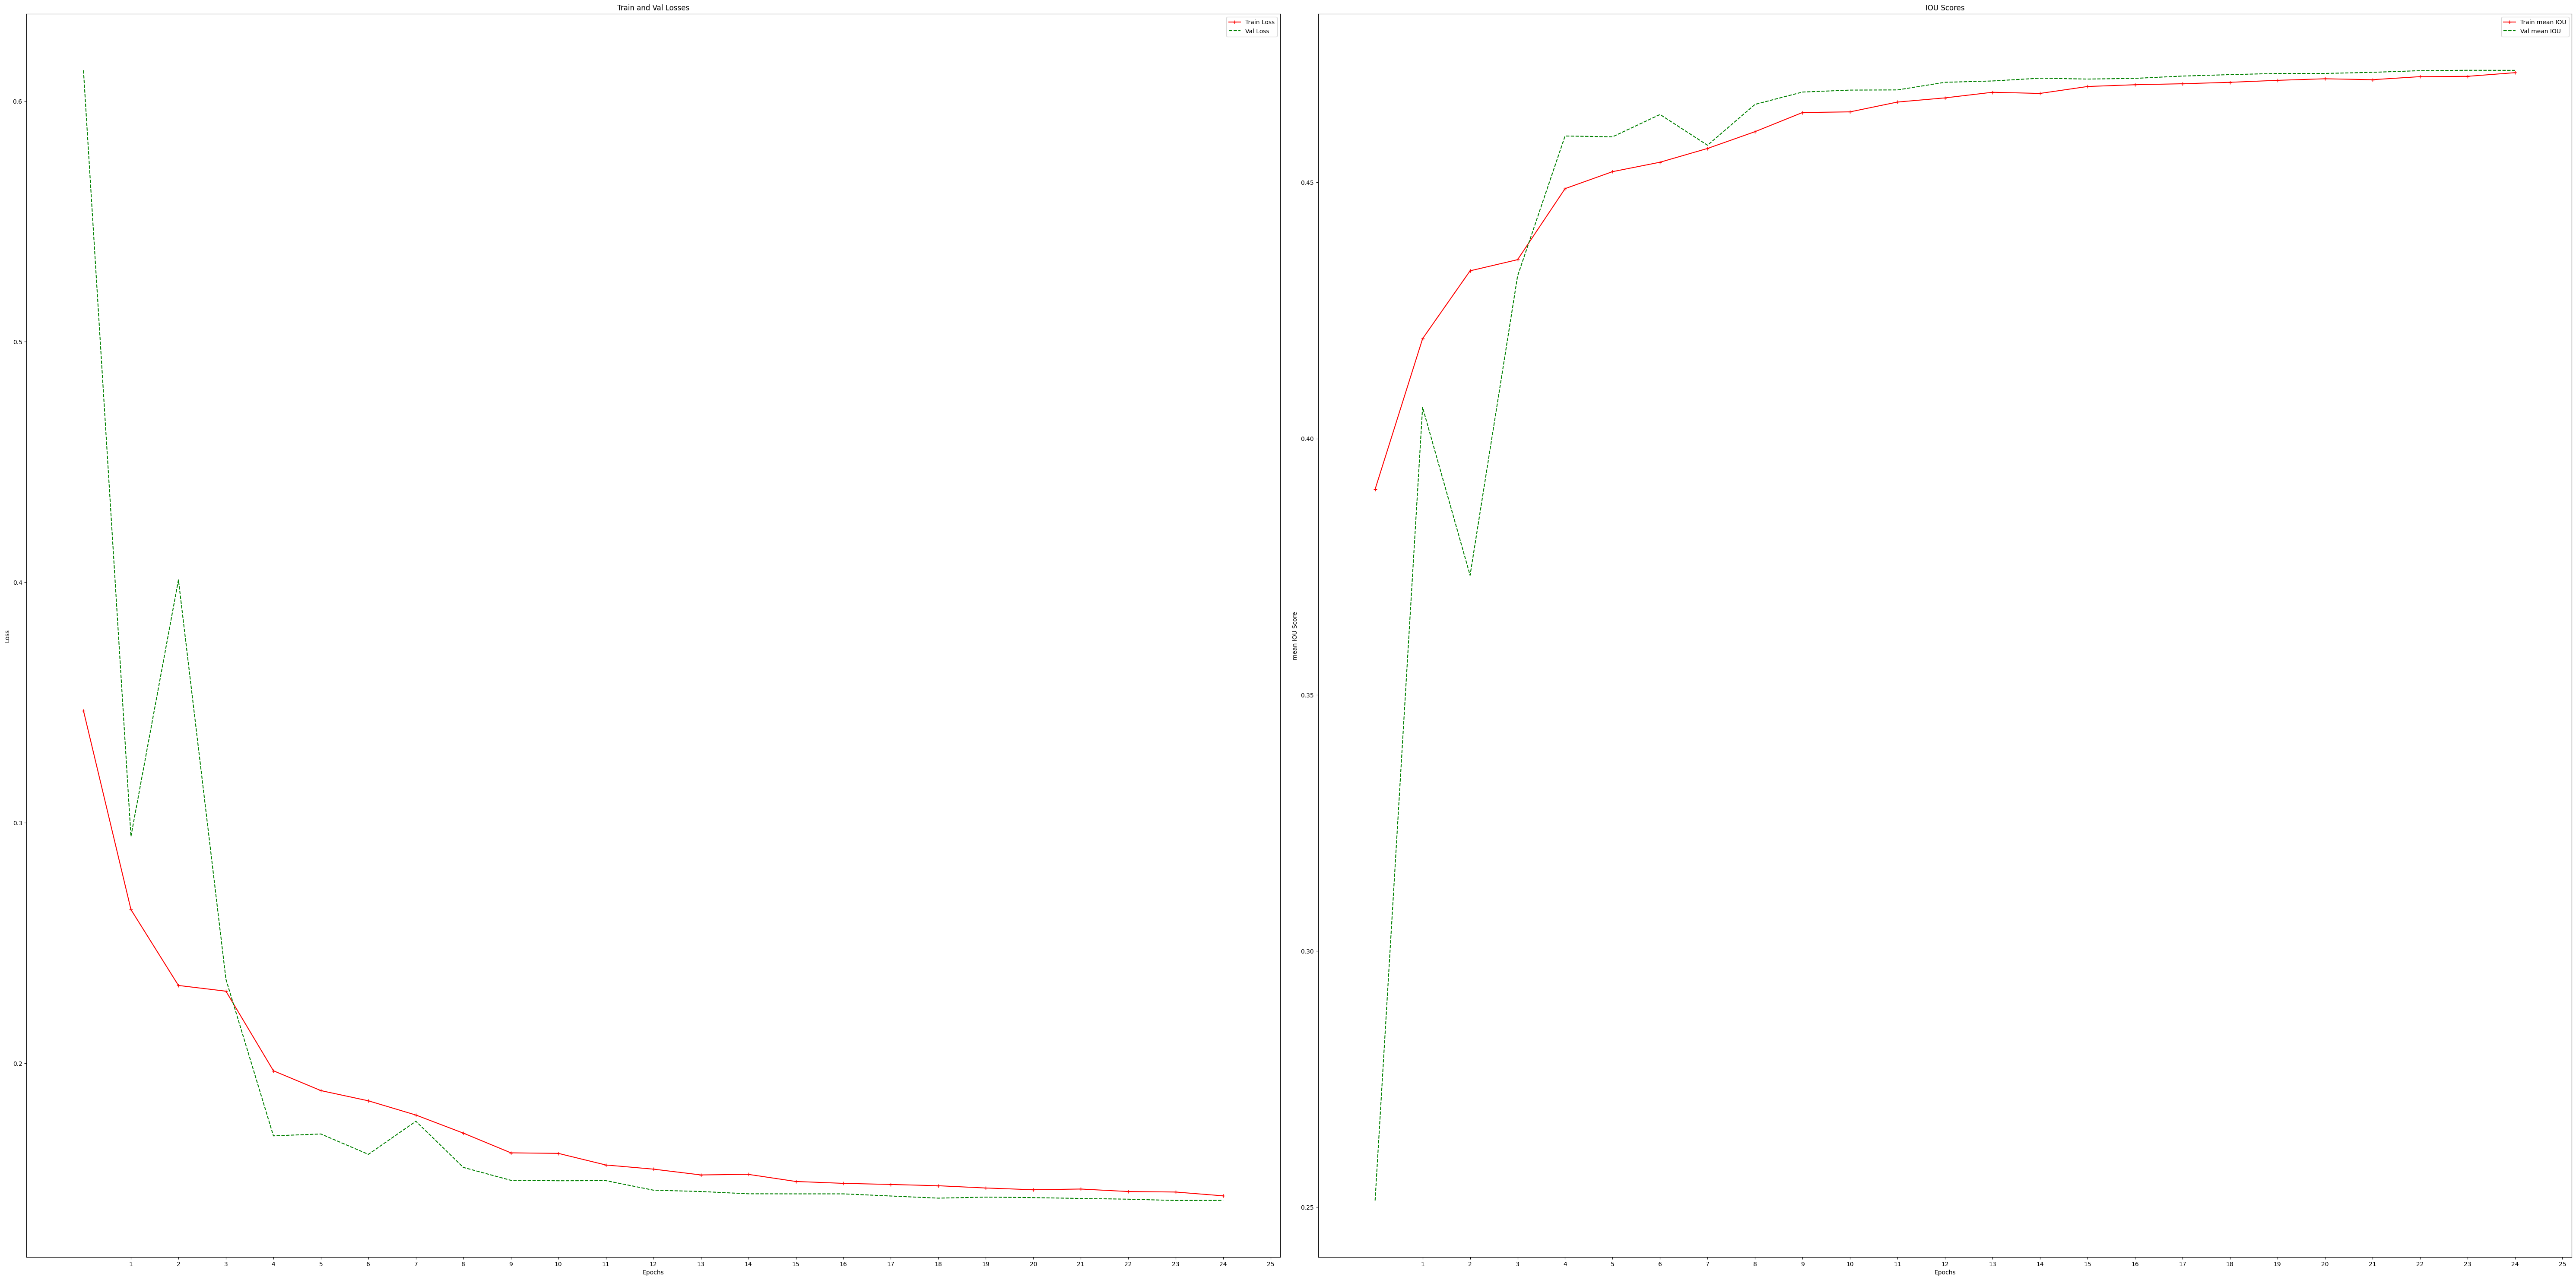

In [19]:
from utils.graphics import plot_graph
plot_graph(root_dir, EPOCH, epoch_tr_loss, epoch_vl_loss, processed_epoch_tr_iou, processed_epoch_vl_iou)

## Sample Results

In [20]:
import glob
model_weight_path = glob.glob(root_dir+"/weights/*pt")[0]
segmentation_model.load_state_dict(torch.load(model_weight_path,map_location=DEVICE))
segmentation_model.eval()

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [21]:
import utils.graphics as utils_graphics
%reload_ext autoreload

In [24]:
inference_results = None
input_images_path = None
validation_data = CustomImageDataset(root_dir=root_dir, total_channels = total_channels, transform=validation_transform, mode="val", device=DEVICE)
validation_dataloader = DataLoader(validation_data, batch_size=3, shuffle=True, pin_memory=True, num_workers=3)
with tqdm(validation_dataloader, unit=" Valid batch") as vepoch:
    for input_images, target_masks, gt_paths in vepoch:
        input_images = input_images.to(DEVICE)
        target_masks = target_masks.to(DEVICE)
        with torch.no_grad():
            output_masks = segmentation_model(input_images)
            output_masks = sigmoid(output_masks)
            output_masks = output_masks.squeeze(dim=1)
            inference_results = output_masks.detach().cpu().numpy()
            inference_results = (inference_results>0.5)*1
            input_images_path = gt_paths
        break

  0%|          | 0/20 [00:00<?, ? Valid batch/s]

  0%|          | 0/20 [00:24<?, ? Valid batch/s]


True

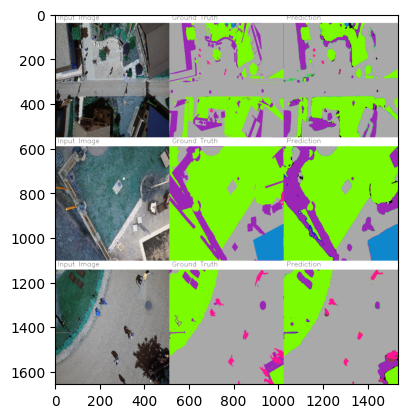

In [25]:
show_dimx, show_dimy = 512, 512
instance_results = []
for idx in range(inference_results.shape[0]):
    image_path = input_images_path[idx]
    tmp_var = image_path.split("/")[-1]
    gt_mask_path = root_dir+"/dataset/masks/"+tmp_var.replace(".jpg",".png")
    image = cv2.imread(image_path)
    image = cv2.resize(image, (show_dimx,show_dimy))
    gt_mask = cv2.imread(gt_mask_path,cv2.IMREAD_UNCHANGED)
    gt_mask = cv2.resize(gt_mask, (show_dimx,show_dimy))
    gt_mask = utils_graphics.generate_rgb_mask(gt_mask, total_channels, individual_class_count)
    pred_mask_numpy = inference_results[idx]
    pred_mask = utils_graphics.generate_mask_from_model_output(pred_mask_numpy, total_channels)
    pred_mask = cv2.resize(pred_mask, (show_dimx,show_dimy))
    image = utils_graphics.add_tag_on_image(image, "Input Image")
    gt_mask = utils_graphics.add_tag_on_image(gt_mask, "Ground Truth")
    pred_mask = utils_graphics.add_tag_on_image(pred_mask, "Prediction")
    single_instance = cv2.hconcat([image, gt_mask, pred_mask])
    instance_results.append(single_instance.copy())

if inference_results.shape[0] == 1:
    combined_results = instance_results[0]
else:
    combined_results = cv2.vconcat(instance_results)

plt.imshow(combined_results)
combined_results = cv2.cvtColor(combined_results, cv2.COLOR_RGB2BGR)
cv2.imwrite(root_dir+"/results/inference_results.jpg",combined_results)